### import important libraries

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random  # Import random for sampling

import torch.nn as nn
import torch.optim as optim


### Image Transformation and Augmentation (Data Preprocessing)

In [20]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize all images to 150x150
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
])

In [21]:
# Set device to CPU
device = torch.device('cpu')

### Loading the data

In [22]:
# Load the training and testing datasets using ImageFolder
train_dir = r'C:\Users\royalgifts\Downloads\brain_tumor1\Training'
test_dir = r'C:\Users\royalgifts\Downloads\brain_tumor1\Testing'

In [23]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
# Print class names
print(f'Classes: {train_dataset.classes}')

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [26]:
import numpy as np
# Calculate class weights based on frequency of each class in the training set
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

class_weights = 1. / np.array(class_counts)
class_weights = torch.FloatTensor(class_weights)

In [27]:
# Print class weights for verification
print(f'Class weights: {class_weights}')

Class weights: tensor([0.0008, 0.0007, 0.0006, 0.0007])


### Image Visualization

In [28]:
# Visualize images by class
def visualize_images_by_class(dataset, num_images=5):
    class_indices = {cls: [] for cls in range(len(dataset.classes))}
    
    # Collect the indices of images for each class
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)

    fig, axes = plt.subplots(len(dataset.classes), num_images, figsize=(num_images * 3, len(dataset.classes) * 3))
    
    for label in class_indices:
        # Randomly select `num_images` images from the class
        selected_indices = random.sample(class_indices[label], num_images)
        for i, idx in enumerate(selected_indices):
            image, _ = dataset[idx]
            axes[label, i].imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to image
            axes[label, i].axis('off')
            if i == 0:
                axes[label, i].set_title(f'Class: {dataset.classes[label]}')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

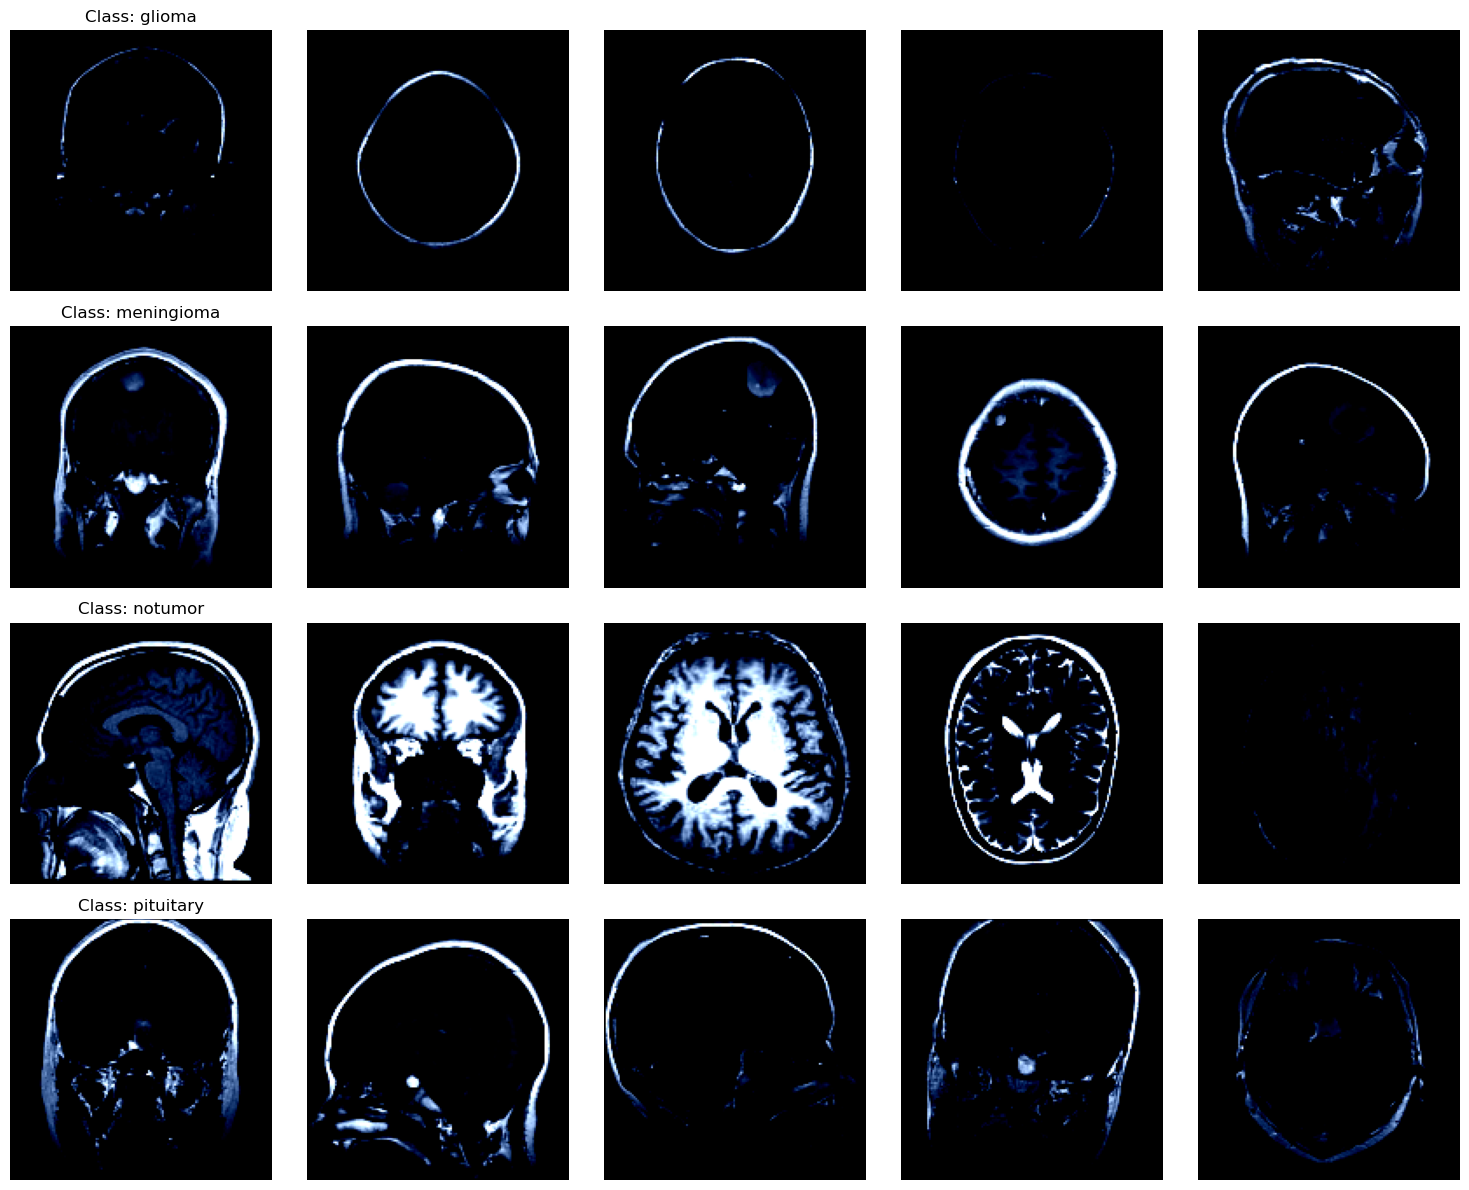

In [29]:
# Show a few images from each class
visualize_images_by_class(train_dataset)

### Model Building

In [30]:
# Define a CNN model
class TumorNet(nn.Module):
    def __init__(self):
        super(TumorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 256)
        self.fc2 = nn.Linear(256, 4)  # 4 classes: glioma, meningioma, pituitary, no tumor
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 18 * 18)  # Flatten the output
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [31]:
# Initialize model, loss function (with class weights), and optimizer
model = TumorNet()
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss to handle class imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

### Training the Model

In [34]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.6931
Epoch [2/10], Loss: 0.3689
Epoch [3/10], Loss: 0.2504
Epoch [4/10], Loss: 0.1731
Epoch [5/10], Loss: 0.1176
Epoch [6/10], Loss: 0.0860
Epoch [7/10], Loss: 0.0713
Epoch [8/10], Loss: 0.0554
Epoch [9/10], Loss: 0.0493
Epoch [10/10], Loss: 0.0339


### Model testing and Evaluation

In [35]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

In [36]:
# Evaluate the model on the test set
evaluate_model(model, test_loader)

Accuracy on test set: 97.10%


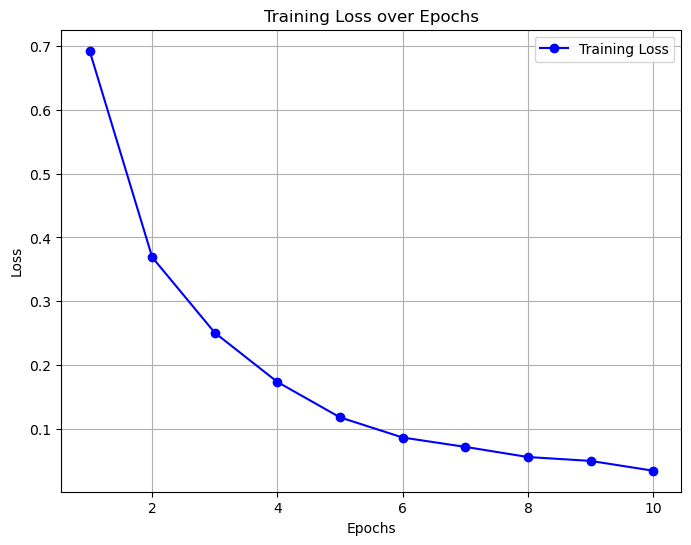

In [40]:
import matplotlib.pyplot as plt

# Manually inputted loss values from your previous training logs
# Replace these with your actual logged loss values
loss_values = [0.6931, 0.3689, 0.2504, 0.1731, 0.1176, 0.0860, 0.0713, 0.0554, 0.0493, 0.0339] 

# Visualization function for training loss
def plot_training_loss(loss_values):
    epochs = range(1, len(loss_values) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss_values, marker='o', color='b', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize
plot_training_loss(loss_values)


### Evaluation using Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [42]:
# Function to evaluate the model on the test set and generate evaluation metrics
def evaluate_model(model, test_loader, classes):
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in test_loader:
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get the index of the highest score (predicted label)
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store actual labels

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report for precision, recall, F1-score
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

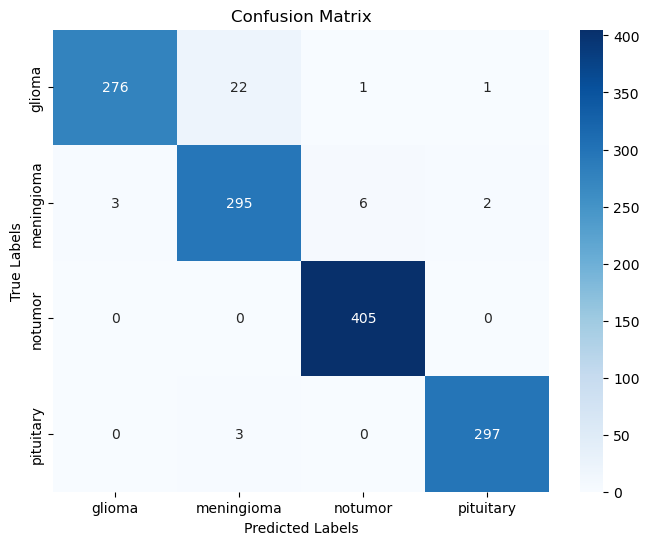

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.92      0.95       300
  meningioma       0.92      0.96      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [43]:
#  usage after training
classes = ['glioma', 'meningioma', 'notumor', 'pituitary'] 
evaluate_model(model, test_loader, classes)

### Evaluation Using ROC curve and AUC

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Binarize the labels for multi-class ROC
    all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # Adjust classes as needed
    all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3])

    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for {class_name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

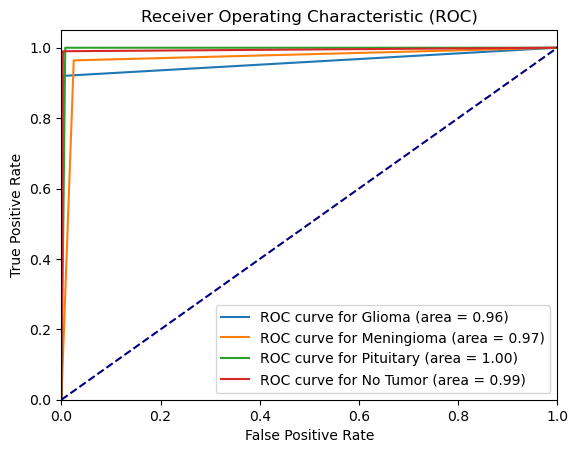

In [51]:
# Usage
plot_roc_curve(model, test_loader, classes=['Glioma', 'Meningioma', 'Pituitary', 'No Tumor'])

### model testing on image

In [44]:
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


# Load and preprocess the image
image_path = "Te-gl_0011.jpg"
image = Image.open(image_path)

In [45]:
# Apply the transformations to the image
image = ImageOps.fit(image, (130, 130), method=Image.Resampling.LANCZOS)
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

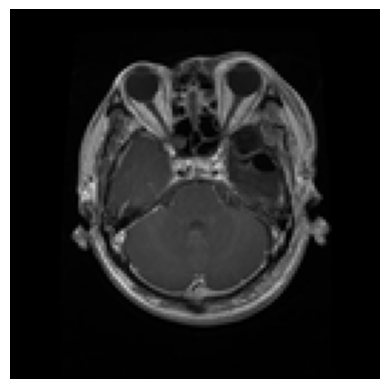

In [46]:
# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [47]:
# Move the tensor to the appropriate device (CPU in this case)
image_tensor = image_tensor.to(device)

In [48]:
print(image_tensor.shape)

torch.Size([1, 3, 150, 150])


In [49]:
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Example usage
prediction = predict(model, image_tensor)
print(f'Predicted class: {prediction}')

Predicted class: 0


In [57]:
# Save the model
torch.save(model.state_dict(), 'brain_tumor_model1.pth')

### Grad-CAM heatmap Visualization

In [58]:
import torch.nn.functional as F
from torchvision import models
import cv2

In [59]:
# Function to compute Grad-CAM for a given image
def compute_gradcam(model, image_tensor, class_idx, target_layer):
    # Set model to evaluation mode
    model.eval()
    
    # Register hook to capture gradients in the target layer
    gradients = []
    activations = []
    
    def hook_function(module, input, output):
        activations.append(output)
        output.register_hook(lambda grad: gradients.append(grad))
    
    target_layer.register_forward_hook(hook_function)
    
    # Forward pass through the model
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    
    # Backpropagate to get gradients with respect to the class of interest
    model.zero_grad()
    class_score = output[:, class_idx]  # Score for the predicted class
    class_score.backward(retain_graph=True)
    
    # Get the gradients and activations from the hooks
    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]
    
    # Compute the weight of each channel in the activation map
    weights = np.mean(gradient, axis=(1, 2))
    
    # Weighted combination of the channels to get the Grad-CAM heatmap
    gradcam = np.zeros(activation.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        gradcam += w * activation[i, :, :]
    
    gradcam = np.maximum(gradcam, 0)  # ReLU activation (only keep positive influences)
    gradcam = cv2.resize(gradcam, (image_tensor.shape[2], image_tensor.shape[3]))
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize
    
    return gradcam

In [60]:
# Function to overlay Grad-CAM heatmap on the original image
def overlay_gradcam_on_image(image, gradcam, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [61]:
# Visualizing Grad-CAM on a sample image
def visualize_gradcam(model, image_tensor, original_image, class_idx, target_layer):
    # Compute Grad-CAM
    gradcam = compute_gradcam(model, image_tensor, class_idx, target_layer)
    
    # Overlay the Grad-CAM heatmap on the original image
    cam_image = overlay_gradcam_on_image(original_image, gradcam)
    
    # Plot the results
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title("Grad-CAM Heatmap")
    
    plt.show()

In [62]:
 #model is trained and loaded
model = TumorNet()
model.load_state_dict(torch.load('brain_tumor_model1.pth'))  # Load your trained model

<All keys matched successfully>

In [64]:
# Preprocess the input image 
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension 
original_image = np.transpose(transform(image).numpy(), (1, 2, 0))  # Convert to (H, W, C)


In [65]:
# Target layer is conv3 in TumorNet
target_layer = model.conv3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


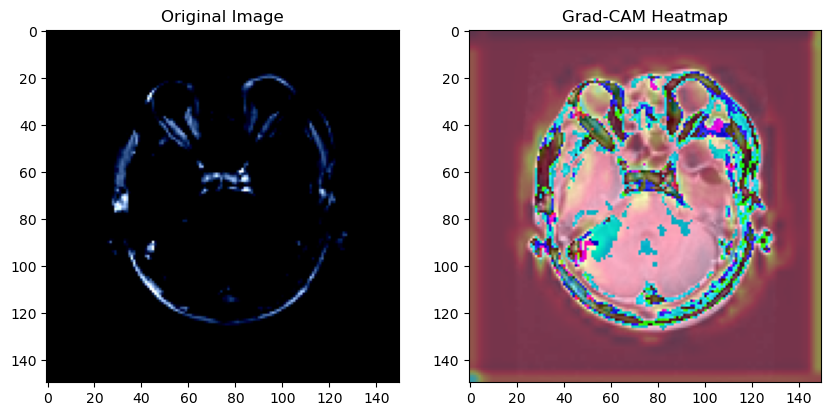

In [66]:
# Visualize Grad-CAM for a specific class (e.g., 0 for Glioma)
class_idx = 0  # Modify based on the target class index
visualize_gradcam(model, image_tensor, original_image, class_idx, target_layer)